In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum

sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

#### Давайте забьем на ограничения $0 \leq x \leq 11, 0 \leq y \leq 11$, потому что для того, чтобы в них попасть, нужно просто аккуратно подобрать стартовую точку для алгоритма. Очевидно по виду функции, что локальные минимумы мы можем найти не только на этом квадрате.

Реализуем метод Нельдера-Мида, применяя стандартные обозначения из википедии https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method

In [2]:
def f(x, y):
    return np.sin(y) * np.exp((1 - np.cos(x))**2) + \
           np.cos(x) * np.exp((1 - np.sin(y))**2) + (x - y)**2


def get_symplex(n):
    """
    Возвращает матрицу размера (n + 1) x n - n + 1 точек, образующих симплекс n - мерного пространства 
    
    :param n: размер пространства, в котором строится симплекс
    :return: симплекс - матрица размер (n + 1) x n
    """
    
    symplex = np.zeros(shape=(n + 1, n))
    for i in range(n):
        symplex[i][i] = 1
    # последняя точка имеет вид -t * (1, 1, ..., 1)
    # ((1+t)**2 + (n-1)*t**2) = 2 - из этого уравнения найдем t
    t = (-1 + (1 + n)**0.5) / n
    symplex[n] = np.zeros(n) - t
    return symplex


def convergence_happened(delta, max_edge):
    # Критерием сходимости будем считать 
    # малое расстояние между центрами соседних симплексов
    # и малую длину ребра симплекса
    max_delta = 10**-6
    return delta < max_delta and max_edge < max_delta

def nelder_mead(f, n, beta=0.5, alpha=1, gamma=2, start_offset=None):
    """
    Возвращает массив из найденных центров треугольников на каждой итерации
    
    :param f: функция, для которой ищется 
    :param n: число аргументов функции f
    :param beta: коэффициент сжатия
    :param alpha: коэффициент отражения
    :param gamma: коэффициент растяжения
    :return: точка минимума функция
    """
    
    # 1) Выбираем n+1 точек, образующих симплекс
    symplex = get_symplex(n)
    
    if start_offset:
        symplex += start_offset
    
    iteration_number = 0
    result = []
    
    delta = 10**9
    max_edge = 10**9
    
    while not convergence_happened(delta, max_edge):
        result.append(symplex.mean(axis=0))
        iteration_number += 1
        if iteration_number >= 2:
            max_edge = -10**9
            for i in range(len(symplex)):
                for j in range(len(symplex)):
                    edge = ((symplex[i] - symplex[j])**2).sum()**0.5
                    max_edge = max(max_edge, edge)
            delta = ((result[-1] - result[-2])**2).sum()**0.5
        
        # Вычисляем значения f в точках симплекса
        f_values = np.array([f(*point) for point in symplex])
        
        # 2) Находим первое и второе самые большие значения, минимальное значение
        # максимальное значение
        ih = np.argmax(f_values)
        xh = symplex[ih]
        fh = f(*xh)
        # второе по величине значение
        ig = np.argsort(f_values)[-2]
        xg = symplex[ig]
        fg = f(*xg)
        # минимальное значение
        il = np.argmin(f_values)
        xl = symplex[il]
        fl = f(*xl)

        # 3) Ищем центр тяжести, выкидывая xh
        xc = (symplex.sum(axis=0) - xh) / n

        # 4) Отражаем xh относительно xc с коэффициентом alpha
        xr = (1 + alpha) * xc - alpha * xh
        fr = f(*xr)

        # 5) Перебор случаев
        if fr <= fl:
            # Растяжение
            xe = (1 - gamma) * xc + gamma * xr
            fe = f(*xe)
            if fe < fr:
                symplex[ih] = xe
                xh = xe
            else:
                symplex[ih] = xr
            continue  # итерация заканчивается
        elif fl < fr <= fg:
            symplex[ih] = xr
            continue  # итерация заканчивается  
        elif fg < fr <= fh:
            symplex[ih] = xr
            fh = fr
            # переходим на следующий шаг
        elif fh < fr:
            pass  # просто переходим на следующий шаг
        else:
            raise ValueError('Unexpected Error')
        
        # 6) Строится точка xs и вычисляется значение в ней
        xs = beta * xh + (1 - beta) * xc
        fs = f(*xs)
        
        # 7) fs < fh
        if fs < fh:
            symplex[ih] = xs
            continue  # итерация заканчивается
        else:
            for i in range(n + 1):
                symplex[i] = xl + (symplex[i] - xl) / 2        
    return result

[[ 1.         0.       ]
 [ 0.         1.       ]
 [-0.3660254 -0.3660254]]


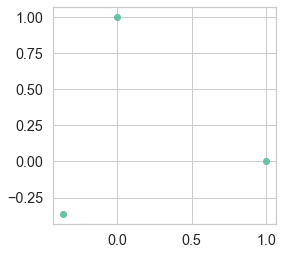

In [3]:
symplex = get_symplex(2)
print(symplex)
x = [r[0] for r in symplex]
y = [r[1] for r in symplex]
plt.figure(figsize=(4, 4))
plt.scatter(x, y)
plt.show()
# Реально симплекс получается

In [4]:
def plot_tests(tests, title):
    colors = [
        'b',
        'g',
        'r',
        'c',
        'm',
        'y',
        'k',
        'purple'
    ]

    plt.figure(figsize=(12, 8))
    for i, test in enumerate(tests):
        color = colors[i]
        points = test['points']
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        plt.plot(x, y, color=color, label=test['label'], ls='--', alpha=0.5)

    # Отмечаем крайние точки работы алгоритма
    for i, test in enumerate(tests):
        color = colors[i]
        last_point = test['points'][-1]
        plt.scatter(last_point[0], last_point[1], marker='*', color=color, s=600, alpha=0.5)
        first_point = test['points'][0]
        plt.scatter(first_point[0], first_point[1], color=color, s=100, alpha=0.5)
    
    # Наносим линии контура на график
    u = np.linspace(-6, 12, 100)
    x, y = np.meshgrid(u, u)
    f_x = [f(x0, y0) for x0, y0 in zip(x, y)]
    plt.contour(x, y, f_x, alpha=0.5)

    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$y$', fontsize=20)
    plt.title(title)
    plt.grid(b=True)
    plt.legend()
    plt.show()

#### Изучаем зависимость от начальной точки (гиперпараметры для всех тестов одинаковые)

In [5]:
alpha = 1
beta = 0.5
gamma = 2

offsets = [
    [0, 0],
    [0, 6],
    [6, 6],
    [6, 0],
]

tests = []

for offset in offsets:
    points = nelder_mead(f, 2, beta=beta, alpha=alpha, gamma=gamma, start_offset=offset)
    start_point = points[0]
    start_point = [round(u, 4) for u in start_point]
    label = f'Начальная точка: {start_point}'
    tests.append({
        'points': points,
        'label': label
    })

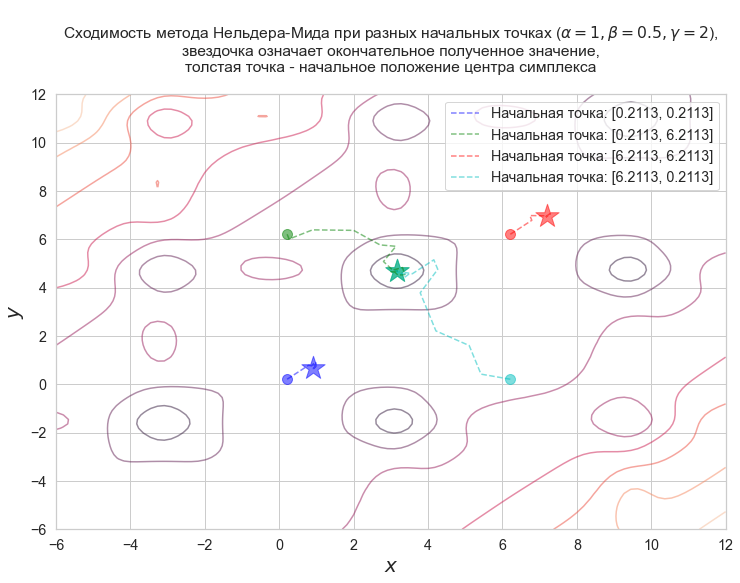

In [6]:
title = \
f"""
Сходимость метода Нельдера-Мида при разных начальных точках \
($\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$),
звездочка означает окончательное полученное значение,
толстая точка - начальное положение центра симплекса
"""
plot_tests(tests, title)

Как видим, при разных значениях начальной точки метод Нельдера-Мида может сходиться к различным точкам (а может и к одинаковым)

#### Изучаем зависимость от гиперпараметров (начальная точка всегда будет одинаковой)

In [7]:
all_params = [
    {'alpha': 1, 'beta': 0.5, 'gamma': 2},
    {'alpha': 0.2, 'beta': 0.5, 'gamma': 2},
    {'alpha': 2, 'beta': 0.2, 'gamma': 0.9},
    {'alpha': 1, 'beta': 0.5, 'gamma': 3},
    {'alpha': 2, 'beta': 3, 'gamma': 0.5},
    {'alpha': 0.2, 'beta': 1.5, 'gamma': 2},
    {'alpha': 1.5, 'beta': 2, 'gamma': 3},
]

tests = []

for params in all_params:
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    
    points = nelder_mead(f, 2, beta=beta, alpha=alpha, gamma=gamma)
    tests.append({
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'points': points,
        'label': f'$\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$'
    })
            

In [8]:
for test in tests:
    point = test["points"][-1]
    f_point = f(*point)
    point = [round(u, 4) for u in point]
    f_point = round(f_point, 4)
    print(f'{test["label"]}, полученная точка минимума: {point}, значение функции в ней: {f_point}')

$\alpha=1, \beta=0.5, \gamma=2$, полученная точка минимума: [0.9055, 0.6653], значение функции в ней: 1.487
$\alpha=0.2, \beta=0.5, \gamma=2$, полученная точка минимума: [0.9704, 0.6991], значение функции в ней: 1.4927
$\alpha=2, \beta=0.2, \gamma=0.9$, полученная точка минимума: [2.8518, -2.1059], значение функции в ней: -45.7473
$\alpha=1, \beta=0.5, \gamma=3$, полученная точка минимума: [3.1529, 4.701], значение функции в ней: -106.7645
$\alpha=2, \beta=3, \gamma=0.5$, полученная точка минимума: [-3.1302, -1.5821], значение функции в ней: -106.7645
$\alpha=0.2, \beta=1.5, \gamma=2$, полученная точка минимума: [0.9699, 0.702], значение функции в ней: 1.4928
$\alpha=1.5, \beta=2, \gamma=3$, полученная точка минимума: [3.1529, 4.701], значение функции в ней: -106.7645


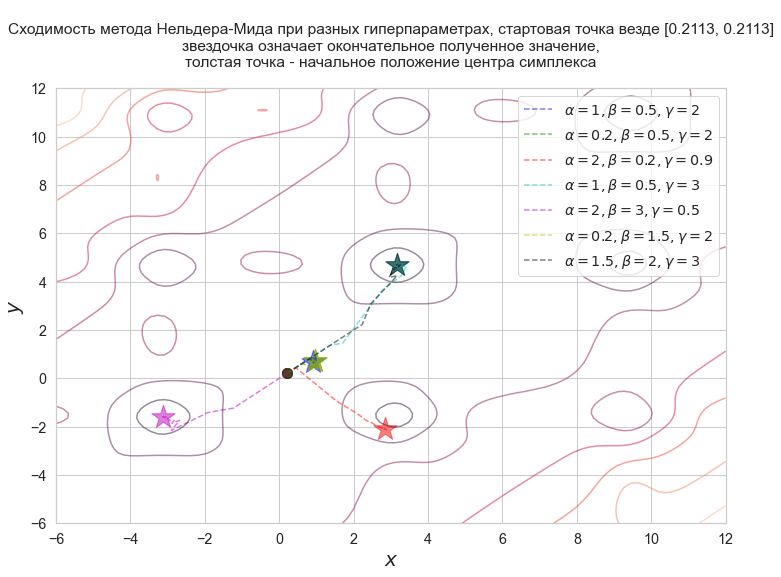

In [9]:
title = \
f"""
Сходимость метода Нельдера-Мида при разных гиперпараметрах, \
стартовая точка везде {[round(u, 4) for u in tests[0]["points"][0]]}
звездочка означает окончательное полученное значение,
толстая точка - начальное положение центра симплекса
"""
plot_tests(tests, title)

Как видим, для одной и той же начальной точки метод может сходиться к различным конечным точкам при разных значениях гиперпараметров. При этом возможна и другая ситуация, когда при разных гиперпараметрах метод сошелся примерно к одному и тому же значению.